In [45]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [46]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegressionCV, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

In [47]:
# setting to see all columns 
pd.set_option('display.max_columns', None)

# Load data and set input/output paths

In [48]:
from os.path import exists
# config: depends whether you're on Google Colab or local


# Get URL from github csv by clicking on Download > Copy Link Address

load_from_google_drive = False

if load_from_google_drive:
  # On google colab
  # Mount GDrive and attach it to the colab for data I/O
  from google.colab import drive
  drive.mount('/content/drive')
  input_dir = '/content/drive/My Drive/datum/vfp/data/input/'
  output_dir = '/content/drive/My Drive/datum/vfp/data/output/'
  os.makedirs(output_dir, exist_ok=True)

else:
  # If using jupyter-lab or jupyter notebook, load locally:
  input_dir = './data/input/'
  output_dir = './data/output/'



In [49]:
df = pd.read_csv(input_dir + 'annotations_avg.csv', index_col = 0)
df

,severity,roughness,breathiness,strain,pitch,loudness (in person),loudness (recording),vfp,noise,y_true,file
0,19.333333,13.333333,6.666667,21.000000,1.666667,0.000000,2.333333,0.333333,0.000000,1,VFP10_Speech.wav
1,62.666667,61.666667,28.333333,56.000000,30.000000,20.000000,2.000000,1.000000,2.000000,1,VFP11_Speech.wav
2,68.333333,45.000000,56.000000,66.666667,50.000000,43.333333,2.333333,1.000000,1.333333,1,VFP12_Speech.wav
3,39.333333,20.000000,13.333333,36.666667,38.333333,16.666667,2.333333,1.000000,0.666667,1,VFP13_Speech.wav
4,65.333333,67.666667,28.333333,59.000000,35.000000,30.000000,1.666667,1.000000,0.666667,1,VFP14_Speech.wav
...,...,...,...,...,...,...,...,...,...,...,...
146,3.333333,2.333333,1.666667,2.333333,0.000000,0.000000,1.666667,0.000000,0.666667,0,VFPNorm76_Speech.wav
147,4.666667,2.666667,0.000000,3.333333,0.000000,0.000000,1.666667,0.000000,1.000000,0,VFPNorm77_Speech.wav
148,4.000000,2.000000,4.000000,2.000000,6.333333,3.000000,1.666667,0.000000,0.000000,0,VFPNorm7_Speech.wav
149,26.000000,26.666667,19.333333,24.000000,13.333333,6.666667,1.666667,0.333333,0.000000,0,VFPNorm8_Speech.wav


# Preprocessing

# Descriptive statistics

In [10]:
def add_top_column(df, top_col, inplace=True):
    if not inplace:
        df = df.copy()
    
    df.columns = pd.MultiIndex.from_product([[top_col], df.columns])
    return df

In [7]:

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'spearman')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
#     print(abs(corr_r) *10000)
    
    marker_size = abs(corr_r) * 10000
    
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = 40 #abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/danielmlow/miniconda3/envs/pydra/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a

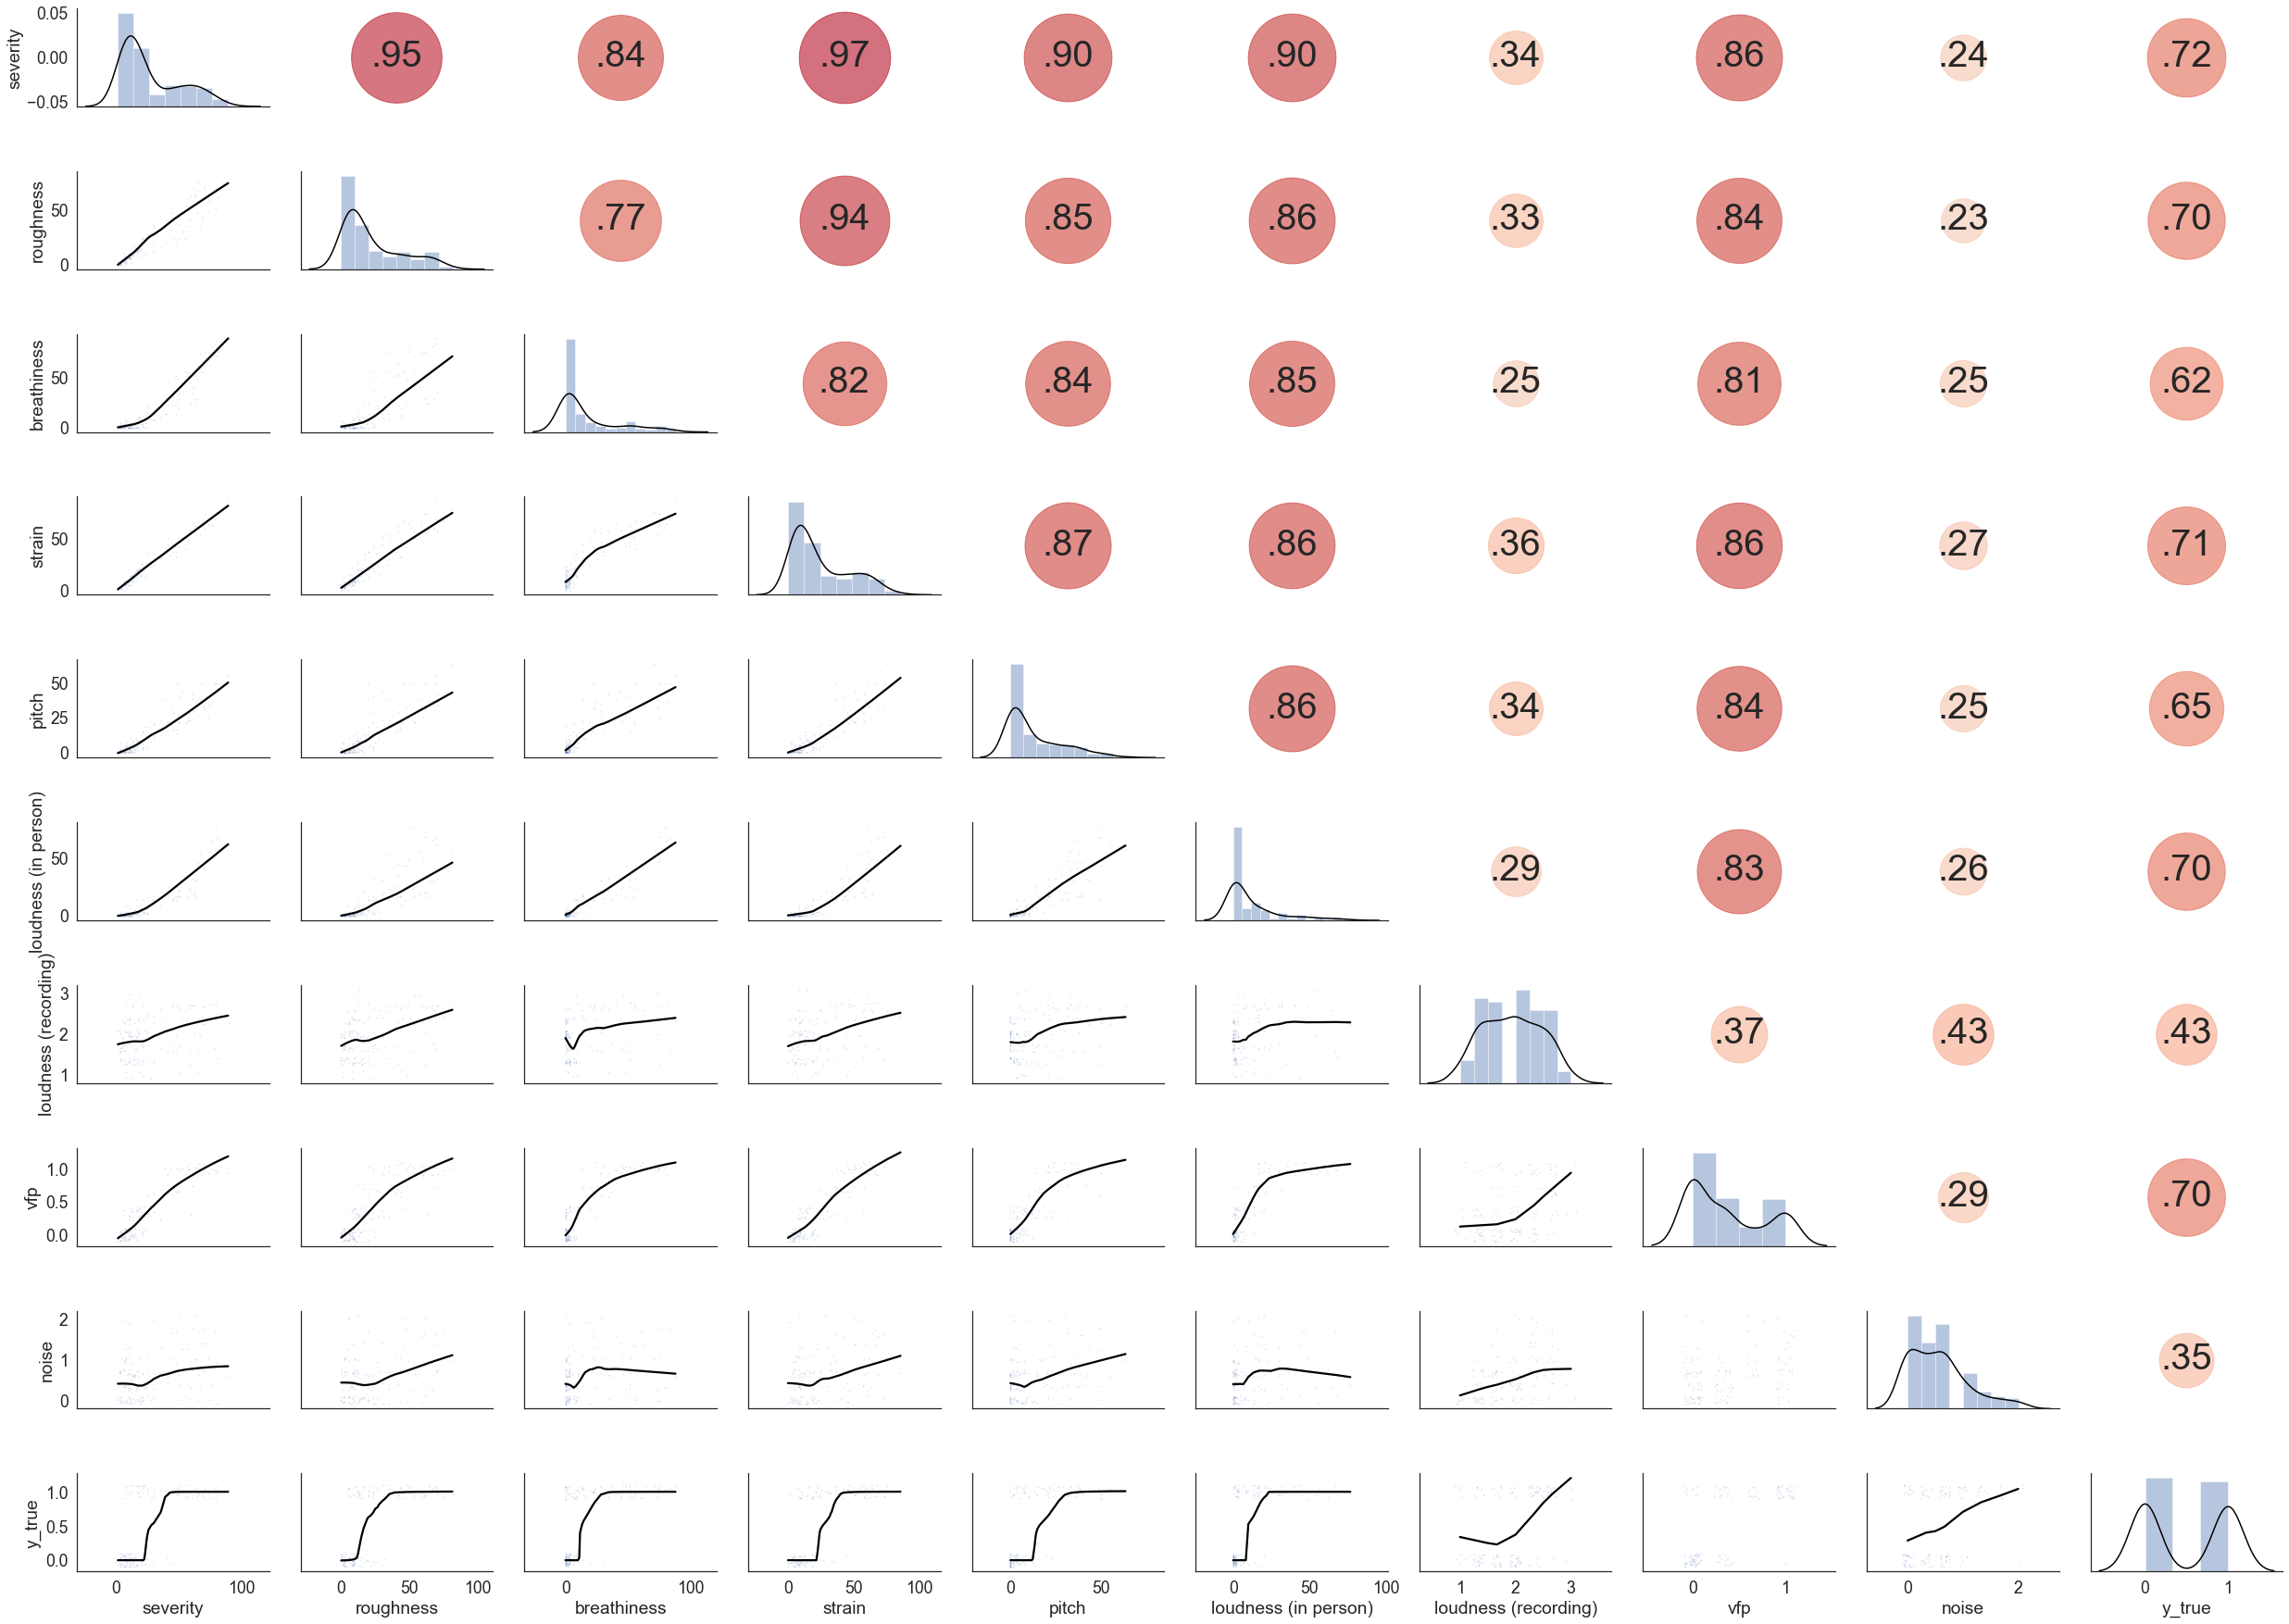

In [8]:
run_toy = False
# Pairwise correlation plot
sns.set(style='white', font_scale=1.6)
# iris = sns.load_dataset('iris')
if run_toy:
  g = sns.PairGrid(df.sample(frac=0.1), aspect=1.4, diag_sharey=False)
else:
  g = sns.PairGrid(df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=True, line_kws={'color': 'black'}, fit_reg=True,
          x_jitter=.1, y_jitter=.1, 
            scatter_kws={"s": 1, "alpha":0.1}
            )
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
plt.show()

In [11]:
df.columns

Index(['severity', 'roughness', 'breathiness', 'strain', 'pitch',
       'loudness (in person)', 'loudness (recording)', 'vfp', 'noise',
       'y_true', 'file'],
      dtype='object')

In [50]:
# Create DFs for each independent variable



variables = ['severity', 'roughness', 'breathiness', 'strain', 'pitch',
       'loudness (in person)']
X = df[variables].values
y = df['y_true'].values


In [51]:
# Observe the range of the covariates
df.describe()

,severity,roughness,breathiness,strain,pitch,loudness (in person),loudness (recording),vfp,noise,y_true
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000
mean,27.479029,22.213024,16.710817,24.678808,12.862031,11.891832,1.944812,0.364238,0.559603,0.490066
std,23.395364,21.146483,23.508341,21.537341,15.018985,17.083468,0.522714,0.400649,0.526816,0.501565
min,1.666667,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,10.000000,6.666667,0.666667,7.833333,1.666667,0.000000,1.583333,0.000000,0.000000,0.000000
50%,17.333333,13.000000,3.333333,16.000000,6.666667,3.333333,2.000000,0.333333,0.500000,0.000000
75%,45.833333,35.000000,23.333333,41.833333,21.666667,16.666667,2.333333,0.666667,0.666667,1.000000
max,89.666667,81.333333,88.000000,85.666667,63.666667,76.666667,3.000000,1.000000,2.000000,1.000000


In [52]:
# Provide clean names for manuscript table
variables

['severity',
 'roughness',
 'breathiness',
 'strain',
 'pitch',
 'loudness (in person)']

In [53]:
# Use cleaner names in the final table

clean_names= dict(zip(
    variables,
    ['severity',
 'roughness',
 'breathiness',
 'strain',
 'pitch',
 'loudness']
    
    ))

clean_names

{'severity': 'severity',
 'roughness': 'roughness',
 'breathiness': 'breathiness',
 'strain': 'strain',
 'pitch': 'pitch',
 'loudness (in person)': 'loudness'}

### Bootstrapping

In [54]:

models = [
    LogisticRegressionCV(solver='liblinear', penalty = 'l1', max_iter = 100),
    SGDClassifier(loss='log', penalty="elasticnet", early_stopping=True, max_iter = 5000),
    MLPClassifier(alpha = 1, max_iter= 1000),
    RandomForestClassifier(n_estimators= 100)
]


names = ['LogisticRegressionCV', "MLPClassifier","RandomForestClassifier",'SGDClassifier']

In [36]:
# bs = cross_validation.Bootstrap(151, n_bootstraps=50, random_state=123,n_test = 0.2)
# bs

In [59]:




# groups = cpp_df['sid'].values

In [66]:
%%time

from sklearn.model_selection import train_test_split

toy = False

filenames = ['clinician_capev', 'clinician_noise']
variables_all = [
    ['severity', 'roughness', 'breathiness', 'strain', 'pitch',
       'loudness (in person)'],
    ['noise', 'loudness (recording)']
]

# filename =  # 'clinician_capev' #     


for filename, variables in zip(filenames, variables_all):

    for null_model in [True, False]:
        X = df[variables].values
        y = df['y_true'].values
        print('\npermute', null_model)

        if toy:
          n_bootstraps = 3
        else:
          n_bootstraps = 50

        if null_model:
            y = np.random.permutation(y) #CHECK


        y_pred_all = {}
        roc_auc_all = {}
        for model, name in zip(models, names):
          y_pred_all[name] = []
          roc_auc_all[name] = []
          pipe = Pipeline(steps=[
                  ('scaler', StandardScaler()), 
                  ('model', model)])

          ## Performing bootstrapping
          for i in range(n_bootstraps):
              #Split the data into training and testing set

              # Chaning the seed value for each iteration
              X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42+i)

          # for train_index, test_index in bs:
          #   X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
              pipe.fit(X_train,y_train)

              # Test     
              y_pred = pipe.predict(X_test)
              roc_auc = roc_auc_score(y_test,y_pred)
              # print(name, roc_auc)
              y_pred_all[name].append(y_pred)
              roc_auc_all[name].append(roc_auc)

        results_i = []
        for name in ['LogisticRegressionCV','MLPClassifier','RandomForestClassifier','SGDClassifier']:
          scores = roc_auc_all.get(name)
          roc_auc_median = np.round(np.median(scores),2)
          roc_auc_5 = np.round(np.percentile(scores, 5),2)
          roc_auc_95 = np.round(np.percentile(scores, 95),2)
          results_str = f'{roc_auc_median} ({roc_auc_5}–{roc_auc_95}; )'
          results_str = results_str.replace('0.', '.')
          results_i.append([name, results_str])

          if null_model:
            print(name, str(roc_auc_median).replace('0.', '.'))
        if not null_model:
            results_i_df = pd.DataFrame(results_i, ).T
            display(results_i_df)
            results_i_df.to_csv(output_dir+f'results_{filename}_permute-{null_model}.csv')




        # pd.DataFrame(y_pred_all)



permute True
LogisticRegressionCV .49
MLPClassifier .51
RandomForestClassifier .53
SGDClassifier .5

permute False


,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.8 (.69–.88; ),.8 (.58–.92; ),.82 (.71–.9; ),.84 (.71–.93; )



permute True
LogisticRegressionCV .5
MLPClassifier .5
RandomForestClassifier .5
SGDClassifier .52

permute False


,0,1,2,3
0,LogisticRegressionCV,MLPClassifier,RandomForestClassifier,SGDClassifier
1,.76 (.59–.86; ),.57 (.36–.81; ),.77 (.62–.87; ),.74 (.62–.83; )


CPU times: user 51.6 s, sys: 1min 3s, total: 1min 54s
Wall time: 40.5 s


In [46]:
pd.DataFrame(y_pred_all).to_csv(output_dir+'annotations_models_y_pred_cape_v.csv')


# SHAP

In [48]:
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 10.3 MB/s eta 0:00:0000:01


In [50]:
initjs()

NameError: ignored

In [52]:
variables

['severity',
 'roughness',
 'breathiness',
 'strain',
 'pitch',
 'loudness (in person)']

In [51]:
shap.initjs()
import shap
explainer = shap.KernelExplainer(pipe.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [77]:
explainer = shap.KernelExplainer(pipe.predict, shap.kmeans(X_train, 5))
shaps = explainer.shap_values(X_test)

  0%|          | 0/31 [00:00<?, ?it/s]

In [83]:
shaps.mean(axis=0)

array([ 0.01189068, -0.00687724,  0.05373208,  0.00265681,  0.00861111,
        0.08885753])

In [66]:

model = RandomForestClassifier(n_estimators= 100).fit(X,y)

maskers = shap.maskers.Independent(X, max_samples=151)

explainer = shap.Explainer(model, maskers)
shap_values = explainer(X, check_additivity=False)

In [73]:
len(shap_values[1])

6

In [74]:
shap.plots.bar(shap_values)
# shap.plots.beeswarm(shap_values)


TypeError: ignored

In [59]:

len(shap_values)

2

In [75]:
sample_ind = 1

shap.plots.waterfall(shap_values[sample_ind], max_display=1)

Exception: ignored

In [76]:
shap.waterfall_plot(explainer.base_values[0], values[0], X[0])

AttributeError: ignored

TypeError: ignored

<Figure size 3600x2400 with 0 Axes>

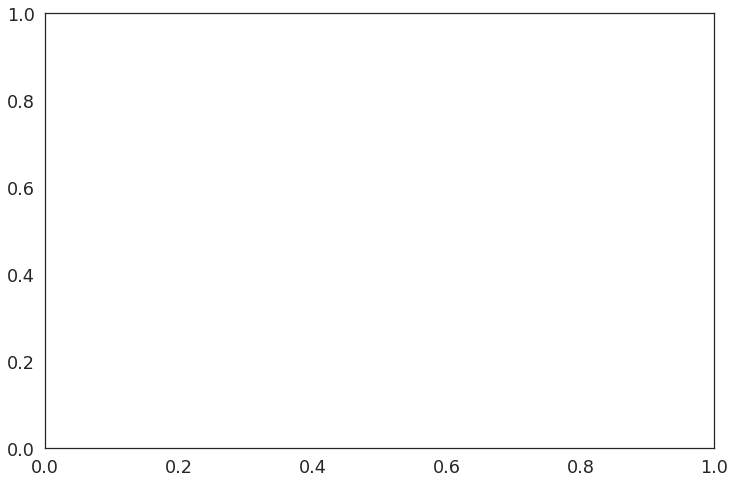

In [27]:
from matplotlib.pyplot import figure

figure(figsize=(12,8), dpi=300)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
fig.set_size_inches(12,8)
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=variables[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
for train_index, test_index in bs:
...    print "TRAIN:", train_index, "TEST:", test_index

Extensions
- feature importance: permutation importance, LOFO
- Generalized Additive Model
- Speech, vision data
- RandomizedSearchCV instead of GridSearchCV
- autoML and auto sklearn
- nested cross-validation for hyperparameter tuning
- repeated measures
  - group shuffle split
  - time series cross-validation 